In [526]:
import numpy as np
import pandas as pd
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [7]:
BASE_URL = "https://raw.githubusercontent.com/susanathey/MCPanel/master/tests/examples_from_paper/california/"

In [40]:
X = pd.read_csv(BASE_URL + "smok_covariates.csv", header=None).values
Y = pd.read_csv(BASE_URL + "smok_outcome.csv", header=None).values.T
treat = pd.read_csv(BASE_URL + "smok_treatment.csv", header=None).values.T
years = np.arange(1970, 2001)

treat = treat[1:,:]
Y = Y[1:,:]

In [663]:
treat.shape

(38, 31)

In [67]:
N, T = Y.shape
number_T0 = 5
T0 = np.ceil(T*(np.arange(1, number_T0+1)*2-1)/(2*number_T0)).astype(int)
N_t = 35

Let's simulate some staggered adoption for a random `N_t` of the population at time `t0`

In [665]:
T0

array([ 4, 10, 16, 22, 28])

In [626]:
np.random.seed(10)

t0 = T0[2]
t0 = 16

N_treat_idx = np.random.choice(np.arange(N), size = 15, replace=False)
T_treat_idx = np.random.choice(np.arange(t0, T), size = 15, replace=False)

treat_mat = np.ones_like(Y)

for n, t in zip(N_treat_idx, T_treat_idx):
    treat_mat[n, t:] = 0

In [627]:
Y_obs = Y * treat_mat

# Run the algorithm

In [686]:
def getPO(A, O):
    
    A_out = np.zeros_like(A)
    
    row_idx = O[:, 0]
    col_idx = O[:, 1]
    
    A_out[tuple(O.T)] = A[tuple(O.T)]

    return A_out

def getPOinv(A, O):
    
    A_out = A.copy()
    
    row_idx = O[:, 0]
    col_idx = O[:, 1]
    
    A_out[tuple(O.T)] = 0

    return A_out

def shrink_lambda(A, lambd):
    
    S,Σ,R = np.linalg.svd(A, full_matrices=False)
    #print(Σ)
    
    Σ = Σ - lambd
    Σ[Σ < 0] = 0
  
    return S @ np.diag(Σ) @ R

In [689]:
A = np.array([[1 ,1],[2,2]])
Ot = np.array([(0, 1),(0, 0)])
A, getPOinv(A, Ot)


(array([[1, 1],
        [2, 2]]), array([[0, 0],
        [2, 2]]))

In [539]:
def run_MCNNM(Y_obs, O, lambd = 10, threshold = 0.01, print_every= 200, max_iters = 20000):
    
    L_prev = getPOinv(Y_obs, O)
    change = 1000
    iters = 0

    while (change > threshold) and (iters < max_iters):
        lam = (len(ids) * lambd) / 2 
        PO = getPO(Y_obs, O)
        PO_inv = getPOinv(L_prev, O)
        
        L_star = PO + PO_inv
        L_new = shrink_lambda(L_star, lambd)

        change = np.linalg.norm((L_prev - L_new))

        loss = ((Y_obs - L_new)**2).sum() / Y.sum()
        real_loss = ((Y - L_new)**2).sum() / Y.sum()
        
        L_prev = L_new
        iters += 1
        
        if (print_every is not None) and ((k % print_every) == 0):
            print(loss, change, real_loss)
            
    return L_new

In [568]:
from sklearn.model_selection import KFold

def get_CV_score(Y_obs, O, lambd, n_folds = 4, verbose=False):
    
    kfold = KFold(n_splits=n_folds, shuffle=True)
    
    mse = 0
    for i, (Otr_idx, Otst_idx) in enumerate(kfold.split(O)):
        Otr = O[Otr_idx]
        Otst = O[Otst_idx]
        if verbose: print(".", end="")
        
        L = run_MCNNM(Y_obs, Otr, lambd, threshold = 1e-10, print_every= 15000, max_iters = 20000)
        
        mse += ((Y_obs[tuple(Otst.T)] - L[tuple(Otst.T)])**2).sum()
    
    return mse / n_folds

def do_CV(Y_obs, O, lambdas = [5, 10, 20, 40], n_tries = 10, verbose=False):
    
    score = {}
    
    for t in tqdm(range(n_tries)):
        run_score = {}
        for l in tqdm(lambdas, leave=False):
            if verbose: print(f"lambda {l}:", end="")
            run_score[l] = get_CV_score(Y_obs, O, l, n_folds = 4, verbose=verbose)
            if verbose: print(f" : {run_score[l]}")
        score[t] = run_score
    return score

# Run cross-validation to find optimal lambda

In [629]:
cv_score = do_CV(Y_obs, O, lambdas=[5, 7, 9, 10, 11, 13, 15, 20], n_tries = 20)

In [630]:
cv_score_df = pd.DataFrame(cv_score)

In [631]:
cv_score_df.mean(axis=1)

5     51691.331345
7     49340.702173
9     48596.922454
10    51582.056636
11    50683.375043
13    51363.003221
15    50077.462441
20    54123.201935
dtype: float64

Text(51.0, 0.5, 'λ')

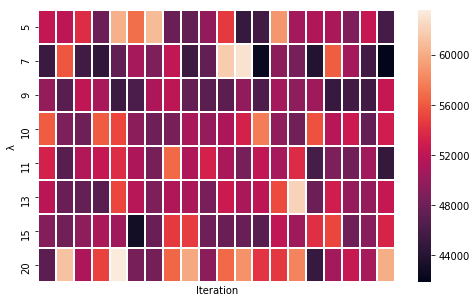

In [691]:
plt.figure(figsize=(8, 5))
ax = sns.heatmap(cv_score_df, linewidths=1)
ax.set_xticks([]);

ax.set_xlabel("Iteration")
ax.set_ylabel("λ")
#plt.savefig("../../sidravi1.github.io/assets/2018_12_02_cross_val.png")

# Run matrix completion with optimal lambda

In [635]:
lambd = 9
threshold = 1e-10
O = np.argwhere(treat_mat)

L = run_MCNNM(Y_obs, O, lambd, threshold, print_every= 1000, max_iters = 20000)

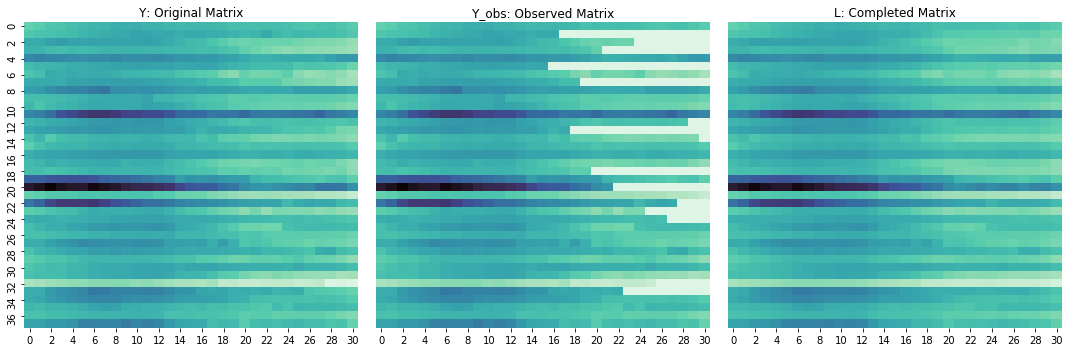

In [667]:
vmin = Y.min()
vmax = Y.max()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(Y, linewidths=0, vmax=vmax, vmin=vmin, ax = ax1, cmap = 'mako_r', cbar=False)
ax1.set_title("Y: Original Matrix")

sns.heatmap(Y_obs, linewidths=0, vmax=vmax, vmin=vmin, ax = ax2, cmap = 'mako_r', cbar=False)
ax2.set_title("Y_obs: Observed Matrix")
ax2.set_yticks([])

sns.heatmap(L, linewidths=0, vmax=vmax, vmin=vmin, ax = ax3, cmap = 'mako_r', cbar=False)
ax3.set_title("L: Completed Matrix")
ax3.set_yticks([])


plt.tight_layout()

plt.savefig("../../sidravi1.github.io/assets/2018_12_02_athey_reconstructed.png")

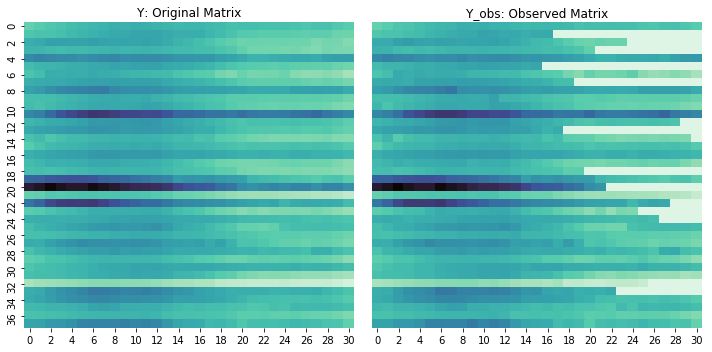

In [668]:
vmin = Y.min()
vmax = Y.max()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(L, linewidths=0, vmax=vmax, vmin=vmin, ax = ax1, cmap = 'mako_r', cbar=False)
ax1.set_title("Y: Original Matrix")

sns.heatmap(Y_obs, linewidths=0, vmax=vmax, vmin=vmin, ax = ax2, cmap = 'mako_r', cbar=False)
ax2.set_title("Y_obs: Observed Matrix")
ax2.set_yticks([])

plt.tight_layout()

plt.savefig("../../sidravi1.github.io/assets/2018_12_02_athey_setup.png")